In [1]:
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    """`path`에서 MNIST 데이터 불러오는 함수를 정의하려고 함 패스와 카인드는 트레인이라는 파라미터를 받아서"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    # path와 뒤에 카인드에서 받은 값을 결합하여 새 경로를 생성해서 labels_path에 집어넣음
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)  
    # 트레인-이미지스-idx와 패스를 결합하여 새 경로를 생성해서 images_path로 집어 넣음
    with open(labels_path, 'rb') as lbpath:
        # labels_path의 경로의 파일을 읽어와서 바이트 모드로 리딩을 한다 
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        # 매직과 n에 각각 라벨을 8바이트로 읽어오고
        # 여기서 >는 빅엔디언(낮은 주소값에 큰 값을 저장하는 방식) I는 부호없는 정수형식으로 
         labels = np.fromfile(lbpath, 
                             dtype=np.uint8)
        # lbpath의 파일을 0~255형식으로 배열을 만들어서 labels에 넣음
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2
        # ★ 픽셀 값을 -1에서 1값으로 정규화한거다라는데 이게 왜 정규환지 잘 모르겠음
    return images, labels
# 결과값으로 images와 정답을 리턴함


IndentationError: unexpected indent (944630996.py, line 19)

In [ ]:
X_train, y_train = load_mnist('', kind='train')
print('행: %d, 열: %d' % (X_train.shape[0], X_train.shape[1]))

행: 60000, 열: 784


In [34]:
X_test,y_test=load_mnist("",kind="t10k")
print("행:%d,열:%d"%(X_test.shape[0],X_test.shape[1]))
# shape를 찍으면 행렬이 튜플형태로 출력되는데 0번칼럼이 행 1번칼럼이 열이다 
# 그래서 코드가 이렇게 된것이고 t10k는 테스트 데이터셋이다.

행:10000,열:784


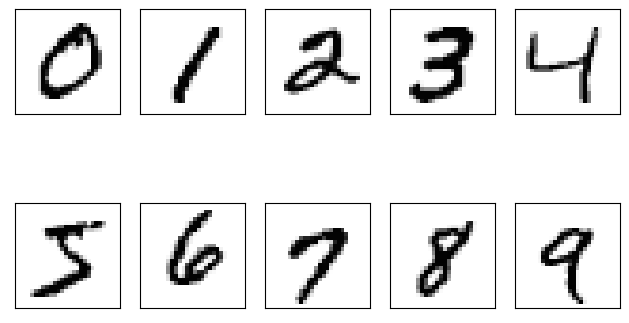

In [28]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True)
# 가로로 두줄 칼럼수는 5개로 X축과 
ax=ax.flatten()
for i in range(10):
    img=X_train[y_train==i][0].reshape(28,28)
    ax[i].imshow(img,cmap="Greys")
# 0이상 10미만으로 리스트를 만들고 그거를 i에 하나씩 넣으면서 실행한다. 
# img에는 X_train을 다시 28*28형태로 만들어서 넣고 근데 어떤놈이냐면 정답이 0,1,2,3.. 인놈들의 0번쨰 값(0,1,2,3,4..칼럼에 다른 손글씨들이 있다)을 가지고 온 것 
# ax[i]에는 ax를 0,1,2,3,4 위치에 회색톤으로 비트맵을 그린다. 
ax[0].set_xticks([])
ax[0].set_yticks([]) 
# 축값을 하나로 공유하는데 공란으로 두겠다라는 뜻임
plt.tight_layout()
# 여백 조정
plt.show()
# 플롯 출력

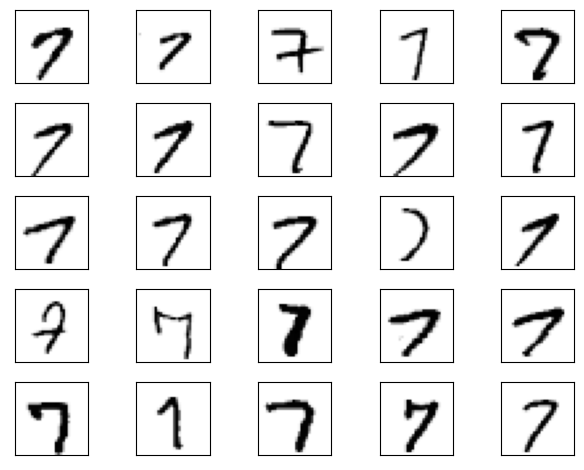

In [37]:
fig,ax=plt.subplots(nrows=5,ncols=5,sharex=True,sharey=True)
ax=ax.flatten()
for i in range(25):
    img=X_train[y_train==7][i].reshape(28,28)
    ax[i].imshow(img,cmap="Greys")
ax[0].set_xticks([])
ax[0].set_yticks([]) 
plt.tight_layout()
plt.show()

# 글씨체 비교하려고 7만 가져와서 보여주는것 

In [39]:
import numpy as np
np.savez_compressed("mnist_scaled.npz",X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test)
# 스케일된 이미지를 새로운 파이썬 셰션에서도 파르게 읽을 수 있는 savez형식으로 저장을 함

In [40]:
mnist=np.load("mnist_scaled.npz")
# 다시 로딩

12.2.2 다층 퍼셉트론 구현   

In [45]:
import numpy as np
import sys


class NeuralNetMLP(object):
    """피드포워드 신경망 / 다층 퍼셉트론 분류기

    매개변수

    ------------
    n_hidden : int (기본값: 30)
        은닉 유닛 개수
    l2 : float (기본값: 0.)
        L2 규제의 람다 값
        l2=0이면 규제 없음. (기본값)
    epochs : int (기본값: 100)
        훈련 세트를 반복할 횟수
    eta : float (기본값: 0.001)
        학습률
    shuffle : bool (기본값: True)
        에포크마다 훈련 세트를 섞을지 여부
        True이면 데이터를 섞어 순서를 바꿉니다
    minibatch_size : int (기본값: 1)
        미니 배치의 훈련 샘플 개수
    seed : int (기본값: None)
        가중치와 데이터 셔플링을 위한 난수 초깃값

    속성
    -----------
    eval_ : dict
      훈련 에포크마다 비용, 훈련 정확도, 검증 정확도를 수집하기 위한 딕셔너리

    """
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        """레이블을 원-핫 방식으로 인코딩합니다

        매개변수
        ------------
        y : 배열, 크기 = [n_samples]
            타깃 값.
        n_classes : int
            클래스 개수

        반환값
        -----------
        onehot : 배열, 크기 = (n_samples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """로지스틱 함수(시그모이드)를 계산합니다"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """정방향 계산을 수행합니다"""

        # 단계 1: 은닉층의 최종 입력
        # [n_samples, n_features] dot [n_features, n_hidden]
        # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # 단계 2: 은닉층의 활성화 출력
        a_h = self._sigmoid(z_h)

        # 단계 3: 출력층의 최종 입력
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_classlabels]
        z_out = np.dot(a_h, self.w_out) + self.b_out

        # 단계 4: 출력층의 활성화 출력
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """비용 함수를 계산합니다

        매개변수
        ----------
        y_enc : 배열, 크기 = (n_samples, n_labels)
            원-핫 인코딩된 클래스 레이블
        output : 배열, 크기 = [n_samples, n_output_units]
            출력층의 활성화 출력 (정방향 계산)

        반환값
        ---------
        cost : float
            규제가 포함된 비용

        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        
        # 다른 데이터셋에서는 극단적인 (0 또는 1에 가까운) 활성화 값이 나올 수 있습니다.
        # 파이썬과 넘파이의 수치 연산이 불안정하기 때문에 "ZeroDivisionError"가 발생할 수 있습니다.
        # 즉, log(0)을 평가하는 경우입니다.
        # 이 문제를 해결하기 위해 로그 함수에 전달되는 활성화 값에 작은 상수를 더합니다.
        #
        # 예를 들어:
        #
        # term1 = -y_enc * (np.log(output + 1e-5))
        # term2 = (1. - y_enc) * np.log(1. - output + 1e-5)
        
        return cost

    def predict(self, X):
        """클래스 레이블을 예측합니다

        매개변수
        -----------
        X : 배열, 크기 = [n_samples, n_features]
            원본 특성의 입력층

        반환값:
        ----------
        y_pred : 배열, 크기 = [n_samples]
            예측된 클래스 레이블

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """훈련 데이터에서 가중치를 학습합니다

        매개변수
        -----------
        X_train : 배열, 크기 = [n_samples, n_features]
            원본 특성의 입력층
        y_train : 배열, 크기 = [n_samples]
            타깃 클래스 레이블
        X_valid : 배열, 크기 = [n_samples, n_features]
            훈련하는 동안 검증에 사용할 샘플 특성
        y_valid : 배열, 크기 = [n_samples]
            훈련하는 동안 검증에 사용할 샘플 레이블

        반환값:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # 가중치 초기화
        ########################

        # 입력층 -> 은닉층 사이의 가중치
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # 은닉층 -> 출력층 사이의 가중치
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # 출력 포맷을 위해
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # 훈련 에포크를 반복합니다
        for i in range(self.epochs):

            # 미니 배치로 반복합니다
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # 정방향 계산
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # 역전파
                ##################

                # [n_examples, n_classlabels]
                delta_out = a_out - y_train_enc[batch_idx]

                # [n_examples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_examples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_examples, n_hidden]
                delta_h = (np.dot(delta_out, self.w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_examples] dot [n_examples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)

                # [n_hidden, n_examples] dot [n_examples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)

                # 규제와 가중치 업데이트
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # 편향은 규제하지 않습니다
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # 편향은 규제하지 않습니다
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # 평가
            #############

            # 훈련하는 동안 에포크마다 평가합니다
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | 비용: %.2f '
                             '| 훈련/검증 정확도: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self
          
      
    

In [46]:
n_epochs = 200

In [48]:
nn = NeuralNetMLP(n_hidden=100, 
                  l2=0.01, 
                  epochs=n_epochs, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)

nn.fit(X_train=X_train[:55000], 
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

# 각각의 하이퍼 파라미터를 넣어서 nn을 만들고 각각의 데이터를 넣어서 학습을 시킴 

c:\ProgramData\Anaconda3\envs\mcl1\lib\site-packages\ipykernel_launcher.py:251: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\ProgramData\Anaconda3\envs\mcl1\lib\site-packages\ipykernel_launcher.py:253: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
200/200 | 비용: 5065.78 | 훈련/검증 정확도: 99.28%/97.98%  

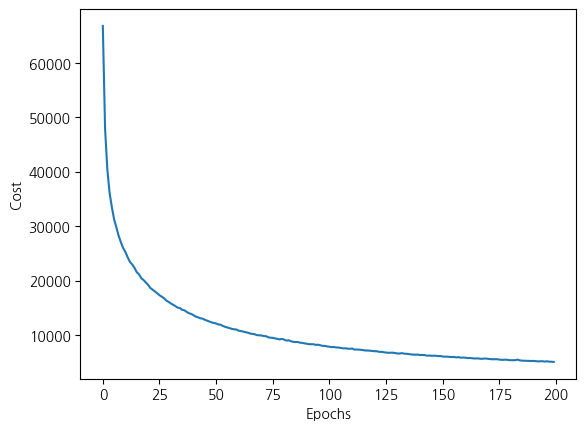

In [49]:
import matplotlib.pyplot as plt

plt.plot(range(nn.epochs), nn.eval_['cost'])
# nn의 에포크와 비용의 그래프를 그림
plt.ylabel('Cost')
plt.xlabel('Epochs')
# 에포크와 비용함수라고 축에 라벨링을 하고
# plt.savefig('images/12_07.png', dpi=300)
plt.show()
# 플롯 출력

# 그래프를 그려보면 비용이 점점 감소하는 것을 알 수 있음

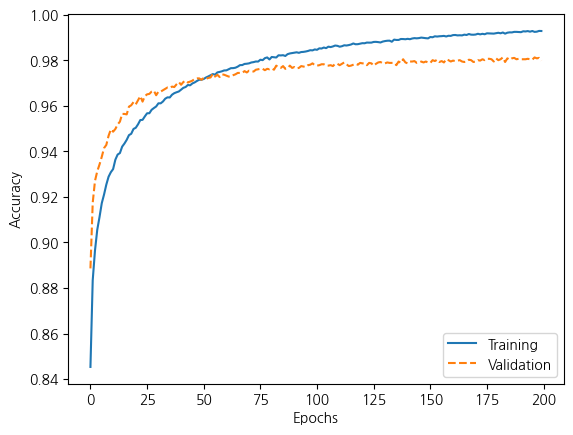

In [54]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='Training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
# plt.savefig('images/12_08.png', dpi=300)
plt.show()
# 밑의 그래프가 의미하는 것은 에포크가 늘어날수록 훈련 정확도와 검증 정확도 사이 간격이 증가한다는 것을 보여준다. 
# 약 50번째 부터 뒤집어지고(훈련정확도가 늘어난다는 뜻이니 과적합이 되기 시작한다는 뜻이다. 
# 과적합을 영향을 줄이기 위해서는 규제 강도를 높이면 된다. 

In [52]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred)
       .astype(np.float) / X_test.shape[0])

print('테스트 정확도: %.2f%%' % (acc * 100))
# 테스트값과 예측값이 같은 것 합을 구해서 속성을 실수로 변경하고 / X_test의 모양의 0번칼럼 값 즉 행 수 즉 전체 갯수를 나눠서 비율을 구한다. 

테스트 정확도: 97.54%


c:\ProgramData\Anaconda3\envs\mcl1\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


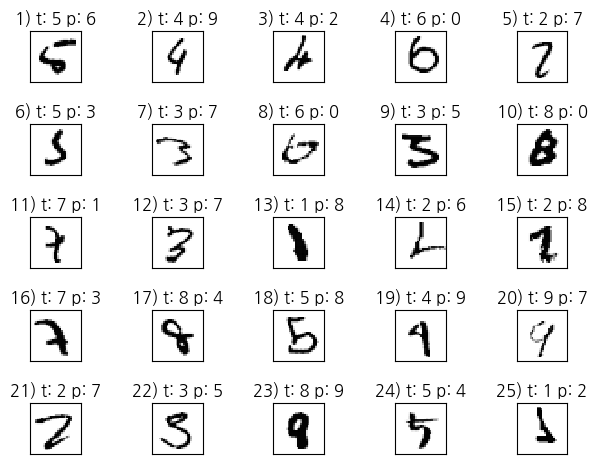

In [55]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]
# 예측값이 안맞았건것 중에서 25개를 가지고 온다. 

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
# fig에는 그림 전체, ax에는 좌표값이 들어간다 서브플롯은 5X5에 x축과 y축을 같이 공유하게끔 그림이 그려질것
ax = ax.flatten()
# 좌표는 평평하게 만든다. 
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))
# 0 이상 25미만으로 리스트를 만들고 i에 하나씩 넣어가면서 반복을 한다. 
# 위에서 정의한거에서 순서대로 다시 28X28로 만든것을 넣고
# 해당 좌표위치에 비트맵을 만든다. 보간법을 써서 이미지는 자연스럽게 
#  타이틀은 i+1(i가 0부터 시작할테니까) i번쨰 라벨값, 예측 값 각각 집어넣는다.
ax[0].set_xticks([])
ax[0].set_yticks([])
# 축값을 하나로 통일하는데 공란으로 두겠다는 의미이다.
plt.tight_layout()
# 여백 줄이기
# plt.savefig('images/12_09.png', dpi=300)
plt.show()
# 플롯 출력

# 아래 그래프에서 t는 레이블(정답) P는 예측값이다